# Import Modules & Define Functions

## Modules

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# General modules & loading data
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange
from IPython.display import display

# Splitting & Oversampling Modules
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter

# Pipeline Building Modules
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Model Modules
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
import xgboost as xgb

# Performance Metrics Modules
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, matthews_corrcoef, fbeta_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
import kaplanmeier as km


## Define Functions

### Train/Test Split

In [4]:
def train_test_split(image_dataframe,n_splits=2, encode_targets = True, apply_SMOTE = True, random_state = 42):
    skf = StratifiedKFold(n_splits)
    
    ifeatures = image_dataframe.iloc[:, 1:-2]
    feature_names = ifeatures.columns
    ifeatures = ifeatures.to_numpy()
    itargets = image_dataframe.iloc[:, -2].to_numpy()
    pids = image_dataframe.iloc[:, 0].to_numpy()
    kaplan_times = image_dataframe.iloc[:, -1].to_numpy()



    for train_index, test_index in skf.split(ifeatures, itargets):
        train_feats, test_feats = ifeatures[train_index], ifeatures[test_index]
        train_targets, test_targets = itargets[train_index], itargets[test_index]
        train_pids, test_pids = pids[train_index], pids[test_index]
        train_kap_times, test_kap_times = kaplan_times[train_index], kaplan_times[test_index]
    
    if encode_targets:
        le = preprocessing.LabelEncoder()
        le.fit(train_targets)
        le.classes_ = le.classes_[::-1]
        train_targets_encoded=le.transform(train_targets)
        test_targets_encoded=le.transform(test_targets)
     
    if apply_SMOTE:
        oversample = SMOTE(k_neighbors=4, random_state=random_state)
        train_feats, train_targets_encoded = oversample.fit_resample(train_feats, train_targets_encoded)
        train_targets = le.inverse_transform(train_targets_encoded) 

    packaged_result = {'feature_names': feature_names,
                       'pre_split_feature_values': ifeatures,
                       'pre_split_targets': itargets,
                       'train_feats': train_feats,
                       'test_feats': test_feats,
                       'train_targets': train_targets,
                       'test_targets': test_targets,
                       'train_targets_encoded': train_targets_encoded,
                       'test_targets_encoded': test_targets_encoded,
                       'train_pids': train_pids,
                       'test_pids': test_pids,
                       'train_kap_times': train_kap_times,
                       'test_kap_times': test_kap_times,
                        }
   
    return  packaged_result

### Single Timepoint Classifier Pipeline

In [5]:
def apply_single_clf(clf, split_data, timepoint,save_path, apply_feature_selection = False, bagging=False, random_seed =42, silent=False):
    
    split_data_timepoint = split_data[timepoint]
    
    feature_names = split_data_timepoint['feature_names'].values.tolist()
    train_feats = split_data_timepoint['train_feats']
    test_feats = split_data_timepoint['test_feats']
    train_targets= split_data_timepoint['train_targets_encoded']
    test_targets = split_data_timepoint['test_targets_encoded']

    
    clf_name = type(clf).__name__
    clf_original = clf_name
    
    if bagging:
        clf_name = clf_name + ' + Bagging'
        clf = BaggingClassifier(base_estimator=clf, n_estimators=20, n_jobs=20, random_state=random_seed)

    elif apply_feature_selection:
        clf_name = clf_name + ' + Feature Selection'
        clf = Pipeline([('feature_selection', SelectFromModel(DecisionTreeClassifier(criterion='entropy', random_state=random_seed))),
                        ('classification', clf)
                        ])
        
    if type(clf).__name__ =='XGBClassifier':
        clf_fit =  clf.fit(train_feats, train_targets, eval_metric='aucpr')
        
    else:
        clf_fit =  clf.fit(train_feats, train_targets)
    
    train_y_pred = clf_fit.predict(train_feats)
    train_y_probas = clf_fit.predict_proba(train_feats)
    train_accuracy = clf_fit.score(train_feats,train_targets)
    train_auc = roc_auc_score(train_targets, train_y_probas[:,1])
    
    train_results = {'accuracy': train_accuracy,
                    'AUC': train_auc,
                    'bi_class_probas': train_y_probas,
                    'predictions': train_y_pred
                    }
       
    test_y_pred = clf_fit.predict(test_feats)
    test_y_probas = clf_fit.predict_proba(test_feats)
    test_accuracy = clf_fit.score(test_feats,test_targets)
    test_auc = roc_auc_score(test_targets, test_y_probas[:,1])
    test_pr_score = average_precision_score(test_targets, test_y_probas[:,1])
    test_f1_score = f1_score(test_targets, test_y_pred)
    test_mcc = matthews_corrcoef(test_targets, test_y_pred)
    test_fb_score = fbeta_score(test_targets, test_y_pred, beta=2)
    
    res = {'model': clf_name,
           'timepoint': timepoint,
           'accuracy': test_accuracy,
           'AUC': test_auc,
           'pr_score': test_pr_score,
           'f1_score': test_f1_score,
           'fb_score': test_fb_score,
           'MCC_Score': test_mcc,
             }   
    results = pd.DataFrame(res,index=[0])
    
    test_results = {'accuracy': test_accuracy,
                    'AUC': test_auc,
                    'pr_score': test_pr_score,
                    'f1_score': test_f1_score,
                    'fb_score': test_fb_score,
                    'MCC_Score': test_mcc,
                    'bi_class_probas': test_y_probas,
                    'predictions': test_y_pred,
                    'results_df': results
                    } 
    
    packaged_result = {'model':clf_name,
                       'train_result': train_results,
                       'test_result': test_results,
                       'timepoint': timepoint
                       }
    
    if apply_feature_selection:
        selected_features = [split_data_timepoint['feature_names'][i] for i in clf_fit['feature_selection'].get_support(indices=True)]
        packaged_result['selected_features']=selected_features

    if not silent:
        print(f'Classifier: {clf_name}')
        print(f'Feature Selection Applied = {apply_feature_selection}')
        if apply_feature_selection:
            print(f'Features Selected:{selected_features}')
        print(f"Number of mislabeled points out of a total {len(test_feats)} points : {(test_targets != test_y_pred).sum()}")

        display(results)

        plt.style.use('classic')
        fig, axs = plt.subplots(1,3, figsize = (22.5,5))
        
        cm = plot_confusion_matrix(clf, test_feats,test_targets, ax=axs[0])
        roc = plot_roc_curve(clf, test_feats,test_targets, ax=axs[1] )
        pr = plot_precision_recall_curve(clf, test_feats,test_targets, ax=axs[2])
        
        fig.suptitle(clf_name)
        packaged_result['confusion_matrix']=cm
        packaged_result['roc']=roc
        
        subfolder = os.path.join(save_path,clf_original)
        subfolder = os.path.join(subfolder,timepoint)
        try:
            os.makedirs(subfolder)
        except:
            pass  
        
        plt.savefig(os.path.join(subfolder,clf_name)+'.png')
        plt.close(fig)
        
    if type(clf).__name__ =='XGBClassifier':    
        clf_fit.get_booster().feature_names = feature_names
        
    packaged_result['fit_model'] = clf_fit
    
    return packaged_result

### Multi Timepoint Classifier Pipeline

In [6]:
def apply_multi_clf(clf, split_data,repeat = 1, apply_feature_selection = False, bagging=False, random_seed =42, silent=False):
    timepoints = list(split_data.keys())
    clf_name = type(clf).__name__
    
    accuracy_history = []
    
    auc_history = []
    pr_score_history = []
    f1_score_history = []
    fb_score_history = []
    mcc_history = []
    
    train_targets= split_data[timepoints[0]]['train_targets_encoded']
    test_targets = split_data[timepoints[0]]['test_targets_encoded']

    for i in trange(repeat, desc = clf_name):
        layer1_outputs = {}
        for t in timepoints:
            layer1_outputs[t] = apply_single_clf(clf,split_data,timepoint = t, silent=True, bagging=bagging)
        
        layer1_train_features = np.concatenate((layer1_outputs['t1']['train_result']['bi_class_probas'],layer1_outputs['t2']['train_result']['bi_class_probas']),axis=1)
        layer1_test_features  = np.concatenate((layer1_outputs['t1']['test_result']['bi_class_probas'],layer1_outputs['t2']['test_result']['bi_class_probas']),axis=1)

        layer2_fit =  clf.fit(layer1_train_features, train_targets)
        
        layer2_y_pred = layer2_fit.predict(layer1_test_features)
        layer2_y_probas = layer2_fit.predict_proba(layer1_test_features)
        layer2_accuracy = layer2_fit.score(layer1_test_features,test_targets)
        layer2_auc = roc_auc_score(test_targets, layer2_y_probas[:,1])
        layer2_pr_score = average_precision_score(test_targets, layer2_y_probas[:,1])
        layer2_f1_score = f1_score(test_targets, layer2_y_pred)
        layer2_fb_score = fbeta_score(test_targets, layer2_y_pred,beta=2)
        layer2_mcc = matthews_corrcoef(test_targets, layer2_y_pred)
    
        accuracy_history.append(layer2_accuracy)
        auc_history.append(layer2_auc)
        pr_score_history.append(layer2_pr_score)
        f1_score_history.append(layer2_f1_score)
        fb_score_history.append(layer2_fb_score)
        mcc_history.append(layer2_mcc)
    
    average_accuracy = sum(accuracy_history)/repeat
    average_auc = sum(auc_history)/repeat
    average_pr_score = sum(pr_score_history)/repeat
    average_f1_score =  sum(f1_score_history)/repeat
    average_fb_score = sum(fb_score_history)/repeat
    average_mcc = sum(mcc_history)/repeat
    
    
    
    res = {'model': clf_name,
           'accuracy': average_accuracy,
           'AUC': average_auc,
           'PR_score': average_pr_score,
           'f1_score': average_f1_score,
           'fb_score': average_fb_score,
           'MCC_Score': average_mcc,
          }
    
    results = pd.DataFrame(res,index=[0])
    fig, axs = plt.subplots(1,3, figsize = (22.5,5))
    cm = plot_confusion_matrix(clf, layer1_test_features,test_targets,ax=axs[0])
    roc = plot_roc_curve(clf, layer1_test_features,test_targets, ax=axs[1] )
    prc = plot_precision_recall_curve(clf, layer1_test_features,test_targets, ax=axs[2])
    fig.suptitle(clf_name)
    # print(f'Test Accuracy: {layer2_accuracy}\nTest AUC: {layer2_auc}\nTest Average Precision: {layer2_pr_score}\nTest f1 Score: {layer2_f1_score}\nTest MCC Score: {layer2_mcc}')
    
    # print(results)
    # print('\n')
    
    packaged_result = {'fit_model': layer2_fit,
                    'accuracy': layer2_accuracy,
                    'AUC': layer2_auc,
                    'MCC_Score': layer2_mcc,
                    'PR_score': layer2_pr_score,
                    'f1_score': layer2_f1_score,
                    'bi_class_probas': layer2_y_probas,
                    'predictions': layer2_y_pred,
                    'results_df': results,
                    'confusion_matrix': cm,
                    'ROC':roc,
                    'prc':prc,
                    'model':clf_name,
                    }
    plt.close(fig)
    # return layer1_features
    return packaged_result

In [7]:
def plot_km(model_output,split_data,folder,save_path,multi=False):
     subfolder = os.path.join(save_path,folder)
     try:
          os.makedirs(subfolder)
     except:
          pass  
     
     if multi:
         d = {'time' : split_data['t1']['test_kap_times'],
               'progressed' : split_data['t1']['test_targets_encoded'],
               'groups' : model_output['predictions'],
               }
         model_name = model_output['model']          
     else:
          d = {'time' : split_data['t1']['test_kap_times'],
               'progressed' : split_data['t1']['test_targets_encoded'],
               'groups' : model_output['test_result']['predictions'],
               }
          model_name = model_output['timepoint'] + '_'+model_output['model']
     
     savepath = os.path.join(subfolder,model_name)
     
     df = pd.DataFrame(d)
     out=km.fit(df['time'],df['progressed'],df['groups'])
     
     km.plot(out,savepath=savepath,title=model_name, full_ylim=True)
     
     plt.close()
    

# Loading Data & Applying Split

Load Data & Perform Random Split

In [8]:
root = os.path.split(os.getcwd())[0]
scores_saves = os.path.join(root, '0.5 Analysis/Scores/')
confusion_saves = os.path.join(root, '0.5 Analysis\Confusion Matrices')
kaplan_saves = os.path.join(root, '0.5 Analysis\Kaplan Meier')
image_feats = {'t1': pd.read_csv(root + '\\0.2 outputs\T1\Merged_Features_T1.csv'),'t2': pd.read_csv(root + '\\0.2 outputs\T2\Merged_Features_T2.csv')}
timepoints = ['t1','t2']
rnd_state = 2
split_data = {'t1':train_test_split(image_feats['t1'], random_state=rnd_state), 't2':train_test_split(image_feats['t2'], random_state=rnd_state)}

# Single Timepoint Models

### Apply Naive Bayes

In [9]:
clf = GaussianNB()
silent = False

nb_results = {'basic': [apply_single_clf(clf, split_data,save_path = confusion_saves, timepoint=t, apply_feature_selection=False, bagging=False, silent=silent) for t in timepoints],
              'feature_selection': [apply_single_clf(clf, split_data,save_path = confusion_saves, timepoint=t, apply_feature_selection=True, bagging=False, silent=silent) for t in timepoints],
              'bagging':[apply_single_clf(clf, split_data,save_path = confusion_saves, timepoint=t, apply_feature_selection=False, bagging=True, silent=silent) for t in timepoints],
              }

nb_df = pd.DataFrame()

for i in list(nb_results.keys()):
    for j in range(len(timepoints)):
        nb_df=nb_df.append(nb_results[i][j]['test_result']['results_df']).reset_index(drop=True)
        plot_km(nb_results[i][j],split_data,folder='Naive Bayes',save_path = kaplan_saves)
        
nb_df.sort_values(by='timepoint',inplace=True)
      
display(nb_df)


Classifier: GaussianNB
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 3


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GaussianNB,t1,0.916667,0.769531,0.59375,0.666667,0.714286,0.624758


Classifier: GaussianNB
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 20


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GaussianNB,t2,0.444444,0.414062,0.119949,0.166667,0.277778,-0.039528


Classifier: GaussianNB + Feature Selection
Feature Selection Applied = True
Features Selected:['CT_wavelet-HHH_glszm_HighGrayLevelZoneEmphasis', 'PET_wavelet-HLH_glrlm_RunVariance', 'PET_wavelet-HHH_firstorder_Skewness']
Number of mislabeled points out of a total 36 points : 5


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GaussianNB + Feature Selection,t1,0.861111,0.765625,0.433929,0.285714,0.263158,0.213201


Classifier: GaussianNB + Feature Selection
Feature Selection Applied = True
Features Selected:['CT_original_glszm_LowGrayLevelZoneEmphasis', 'CT_wavelet-HLL_glszm_ZonePercentage', 'PET_wavelet-HLH_firstorder_Skewness', 'PET_wavelet-HHH_firstorder_TotalEnergy']
Number of mislabeled points out of a total 36 points : 8


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GaussianNB + Feature Selection,t2,0.777778,0.523438,0.359028,0.2,0.227273,0.079057


Classifier: GaussianNB + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 3


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GaussianNB + Bagging,t1,0.916667,0.765625,0.552083,0.666667,0.714286,0.624758


Classifier: GaussianNB + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 19


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GaussianNB + Bagging,t2,0.472222,0.46875,0.128535,0.173913,0.285714,-0.019672


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GaussianNB,t1,0.916667,0.769531,0.593750,0.666667,0.714286,0.624758
2,GaussianNB + Feature Selection,t1,0.861111,0.765625,0.433929,0.285714,0.263158,0.213201
4,GaussianNB + Bagging,t1,0.916667,0.765625,0.552083,0.666667,0.714286,0.624758
1,GaussianNB,t2,0.444444,0.414062,0.119949,0.166667,0.277778,-0.039528
3,GaussianNB + Feature Selection,t2,0.777778,0.523438,0.359028,0.200000,0.227273,0.079057
5,GaussianNB + Bagging,t2,0.472222,0.468750,0.128535,0.173913,0.285714,-0.019672


### Apply AdaBoostClassifier

Classifier: AdaBoostClassifier
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 2


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,AdaBoostClassifier,t1,0.944444,0.929688,0.826923,0.666667,0.555556,0.685994


Classifier: AdaBoostClassifier
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 4


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,AdaBoostClassifier,t2,0.888889,0.828125,0.345833,0.333333,0.277778,0.300123


Classifier: AdaBoostClassifier + Feature Selection
Feature Selection Applied = True
Features Selected:['CT_wavelet-HHH_glszm_HighGrayLevelZoneEmphasis', 'PET_wavelet-HLH_glrlm_RunVariance', 'PET_wavelet-HHH_firstorder_Skewness']
Number of mislabeled points out of a total 36 points : 5


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,AdaBoostClassifier + Feature Selection,t1,0.861111,0.867188,0.383824,0.444444,0.47619,0.369175


Classifier: AdaBoostClassifier + Feature Selection
Feature Selection Applied = True
Features Selected:['CT_original_glszm_LowGrayLevelZoneEmphasis', 'CT_wavelet-HLL_glszm_ZonePercentage', 'PET_wavelet-HLH_firstorder_Skewness', 'PET_wavelet-HHH_firstorder_TotalEnergy']
Number of mislabeled points out of a total 36 points : 10


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,AdaBoostClassifier + Feature Selection,t2,0.722222,0.28125,0.097685,0.0,0.0,-0.158114


Classifier: AdaBoostClassifier + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 3


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,AdaBoostClassifier + Bagging,t1,0.916667,0.859375,0.795455,0.4,0.294118,0.478091


Classifier: AdaBoostClassifier + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 4


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,AdaBoostClassifier + Bagging,t2,0.888889,0.890625,0.670673,0.5,0.5,0.4375


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,AdaBoostClassifier,t1,0.944444,0.929688,0.826923,0.666667,0.555556,0.685994
2,AdaBoostClassifier + Feature Selection,t1,0.861111,0.867188,0.383824,0.444444,0.476190,0.369175
4,AdaBoostClassifier + Bagging,t1,0.916667,0.859375,0.795455,0.400000,0.294118,0.478091
1,AdaBoostClassifier,t2,0.888889,0.828125,0.345833,0.333333,0.277778,0.300123
3,AdaBoostClassifier + Feature Selection,t2,0.722222,0.281250,0.097685,0.000000,0.000000,-0.158114
5,AdaBoostClassifier + Bagging,t2,0.888889,0.890625,0.670673,0.500000,0.500000,0.437500


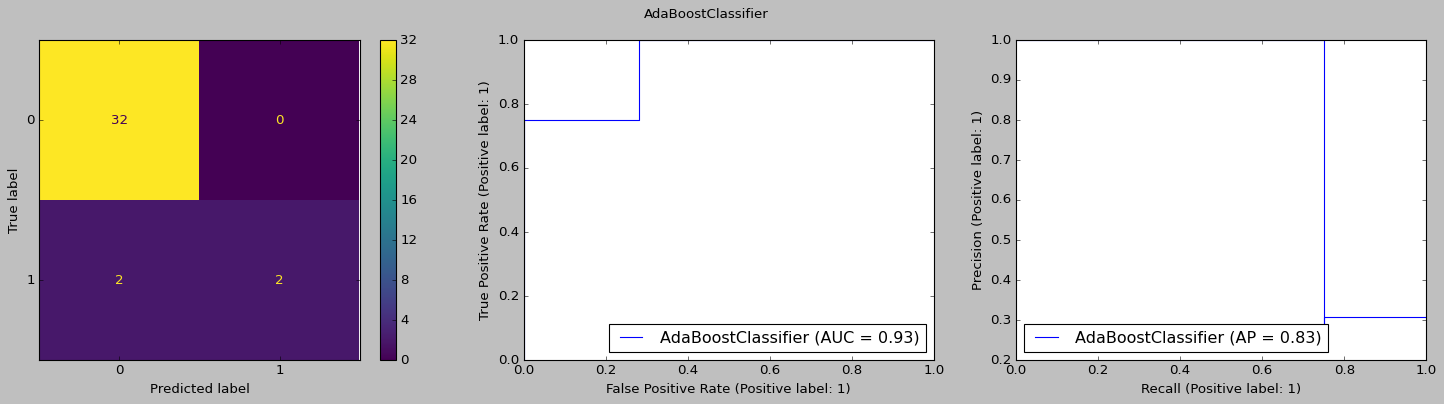

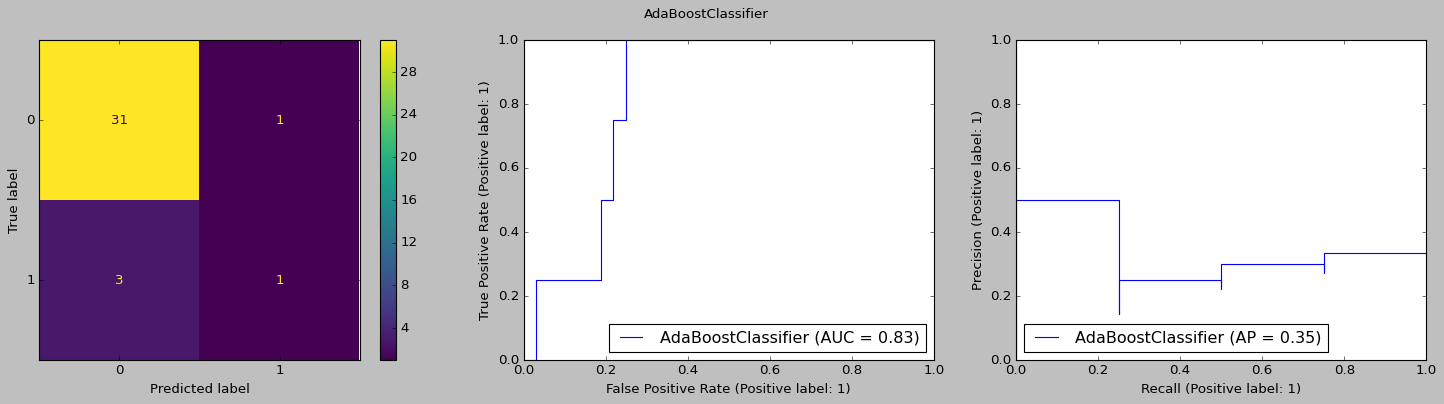

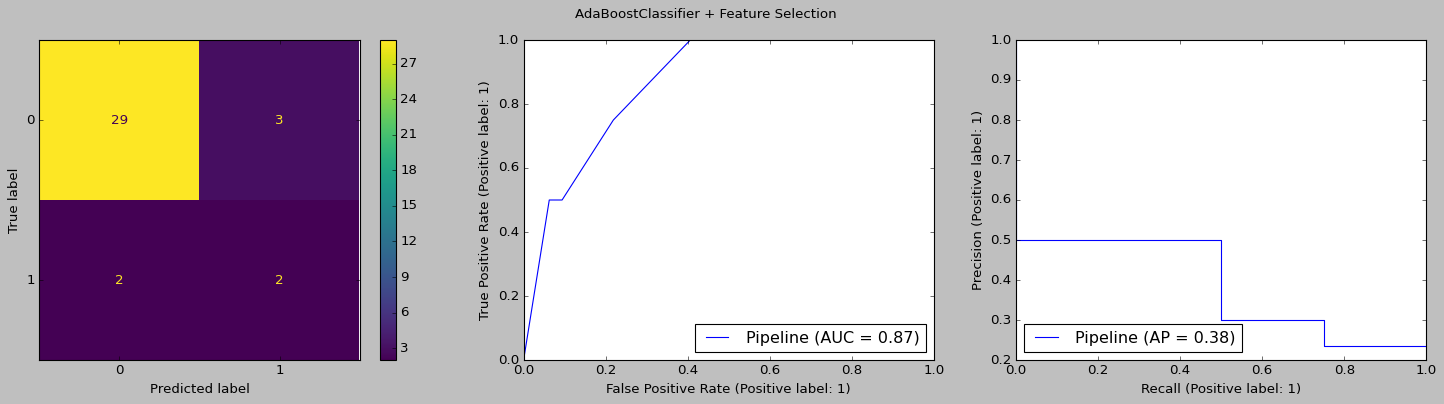

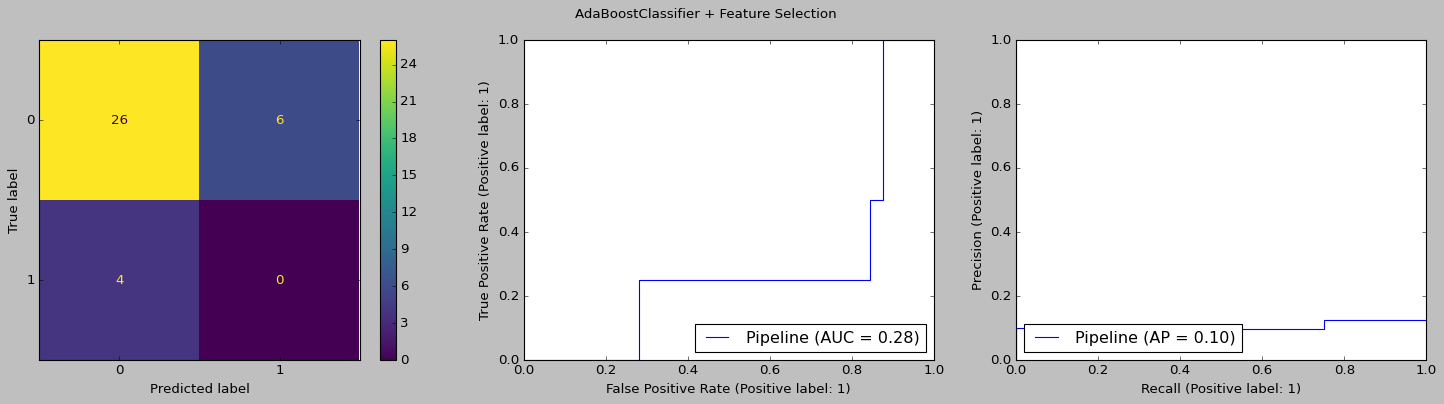

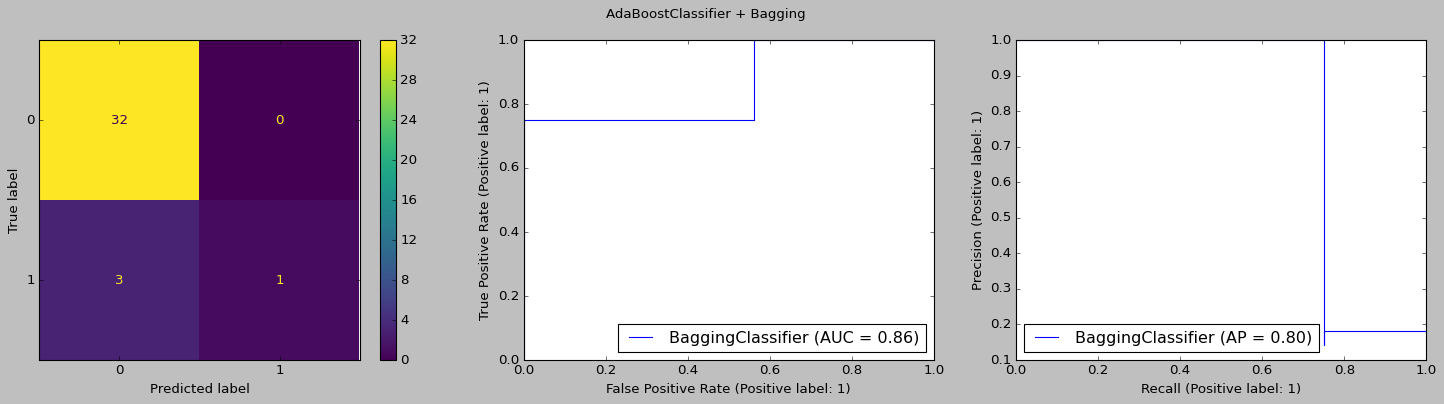

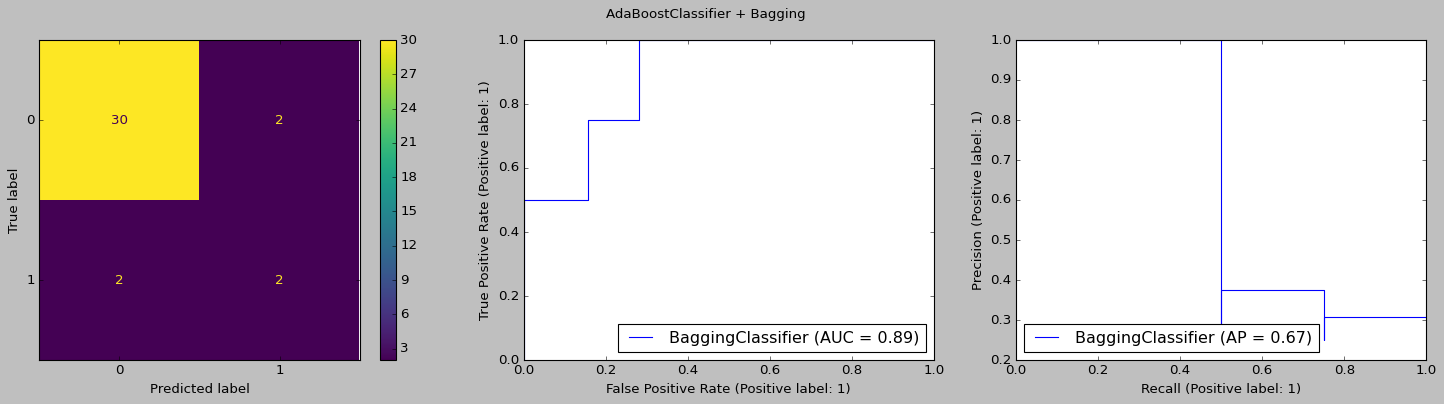

In [8]:
clf = AdaBoostClassifier()
silent =False
ada_results = {'basic': [apply_single_clf(clf, split_data,save_path = confusion_saves, timepoint=t, apply_feature_selection=False, bagging=False, silent=silent) for t in timepoints],
              'feature_selection': [apply_single_clf(clf, split_data,save_path = confusion_saves, timepoint=t, apply_feature_selection=True, bagging=False, silent=silent) for t in timepoints],
              'bagging':[apply_single_clf(clf, split_data,save_path = confusion_saves, timepoint=t, apply_feature_selection=False, bagging=True, silent=silent) for t in timepoints],
              }

ada_df = pd.DataFrame()

for i in list(ada_results.keys()):
    for j in range(len(timepoints)):
        ada_df=ada_df.append(ada_results[i][j]['test_result']['results_df']).reset_index(drop=True)
        plot_km(ada_results[i][j],split_data,folder='AdaBoost',save_path = kaplan_saves)
ada_df.sort_values(by='timepoint',inplace=True)
      
display(ada_df)




### GradientBoosting

GradientBoosting base model

Classifier: GradientBoostingClassifier
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 4


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GradientBoostingClassifier,t1,0.888889,0.9375,0.525,0.6,0.681818,0.553399


Classifier: GradientBoostingClassifier
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 8


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GradientBoostingClassifier,t2,0.777778,0.359375,0.111111,0.0,0.0,-0.125


Classifier: GradientBoostingClassifier + Feature Selection
Feature Selection Applied = True
Features Selected:['CT_wavelet-HHH_glszm_HighGrayLevelZoneEmphasis', 'PET_wavelet-HLH_glrlm_RunVariance', 'PET_wavelet-HHH_firstorder_Skewness']
Number of mislabeled points out of a total 36 points : 5


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GradientBoostingClassifier + Feature Selection,t1,0.861111,0.703125,0.255556,0.444444,0.47619,0.369175


Classifier: GradientBoostingClassifier + Feature Selection
Feature Selection Applied = True
Features Selected:['CT_original_glszm_LowGrayLevelZoneEmphasis', 'CT_wavelet-HLL_glszm_ZonePercentage', 'PET_wavelet-HLH_firstorder_Skewness', 'PET_wavelet-HHH_firstorder_TotalEnergy']
Number of mislabeled points out of a total 36 points : 10


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GradientBoostingClassifier + Feature Selection,t2,0.722222,0.40625,0.111111,0.0,0.0,-0.158114


Classifier: GradientBoostingClassifier + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 1


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GradientBoostingClassifier + Bagging,t1,0.972222,0.921875,0.821429,0.857143,0.789474,0.852803


Classifier: GradientBoostingClassifier + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 5


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GradientBoostingClassifier + Bagging,t2,0.861111,0.789062,0.293108,0.545455,0.652174,0.496292


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GradientBoostingClassifier,t1,0.888889,0.937500,0.525000,0.600000,0.681818,0.553399
2,GradientBoostingClassifier + Feature Selection,t1,0.861111,0.703125,0.255556,0.444444,0.476190,0.369175
4,GradientBoostingClassifier + Bagging,t1,0.972222,0.921875,0.821429,0.857143,0.789474,0.852803
1,GradientBoostingClassifier,t2,0.777778,0.359375,0.111111,0.000000,0.000000,-0.125000
3,GradientBoostingClassifier + Feature Selection,t2,0.722222,0.406250,0.111111,0.000000,0.000000,-0.158114
5,GradientBoostingClassifier + Bagging,t2,0.861111,0.789062,0.293108,0.545455,0.652174,0.496292


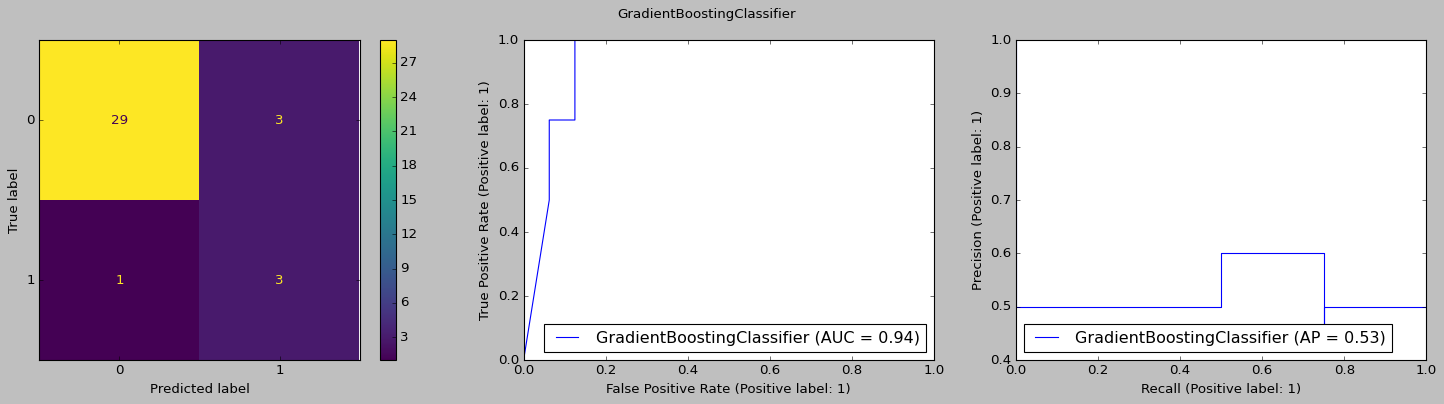

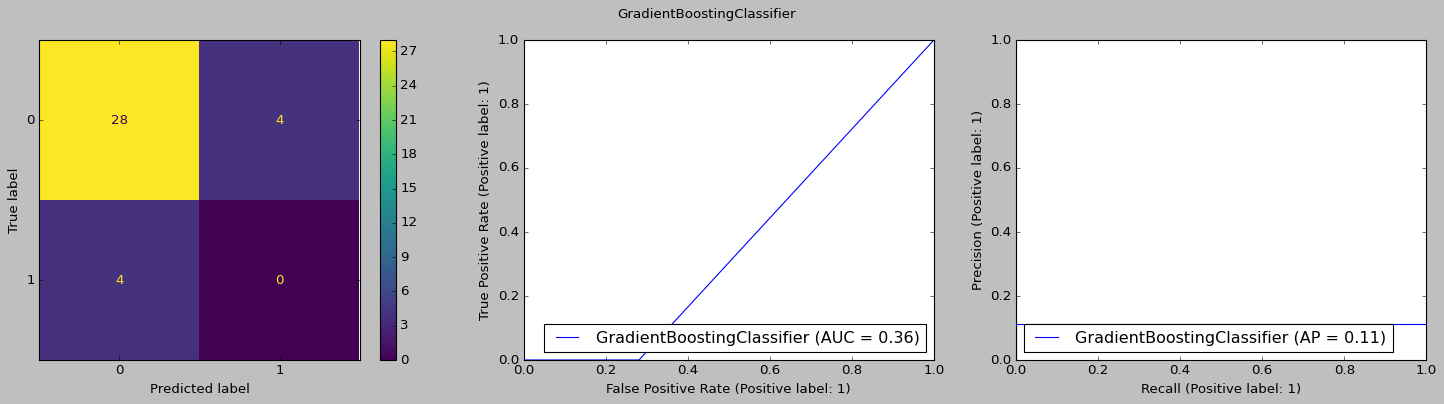

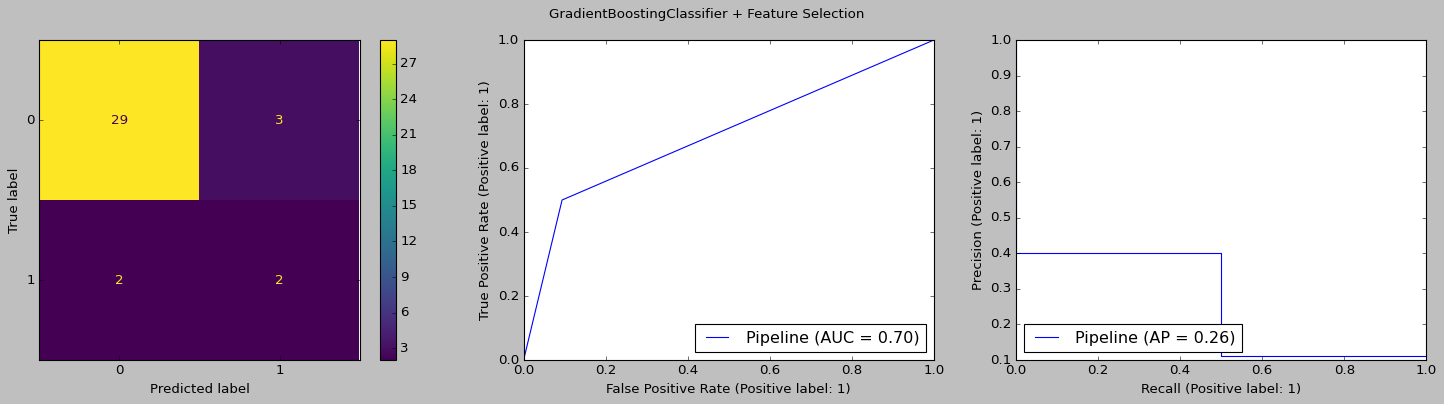

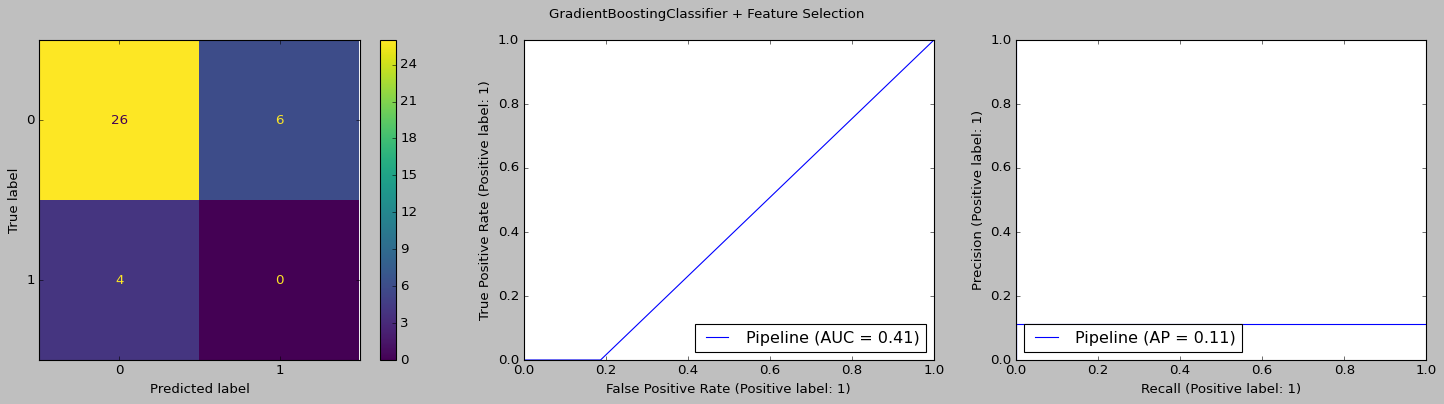

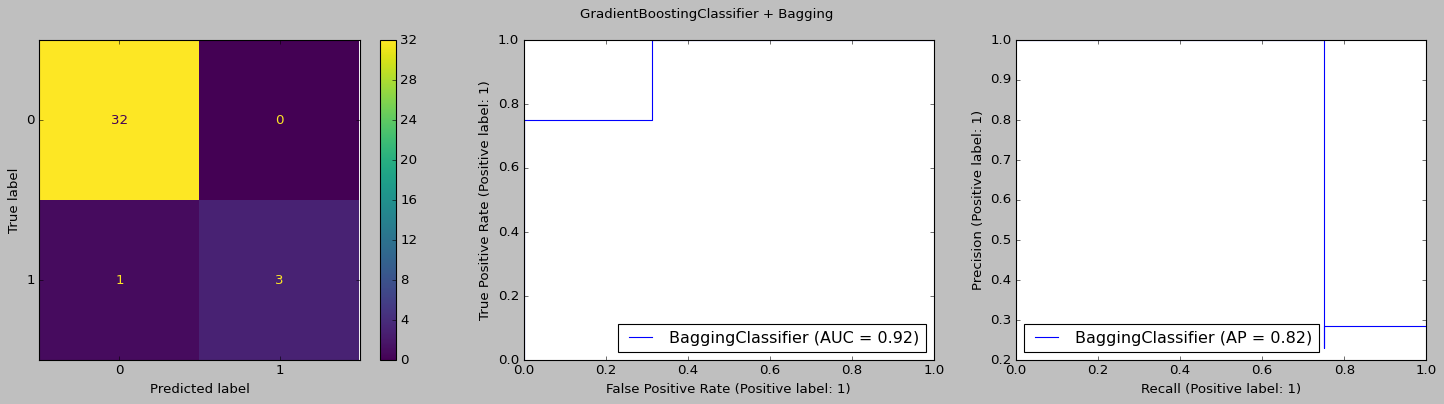

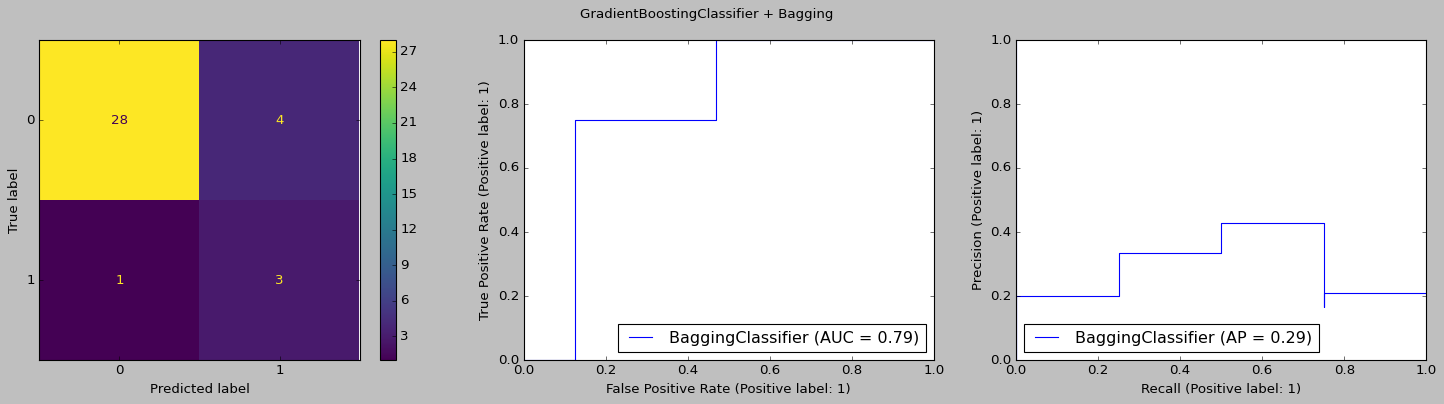

In [9]:
clf = GradientBoostingClassifier()

silent =False

gbc_results = {'basic': [apply_single_clf(clf, split_data,save_path = confusion_saves, timepoint=t, apply_feature_selection=False, bagging=False, silent=silent) for t in timepoints],
              'feature_selection': [apply_single_clf(clf, split_data,save_path = confusion_saves, timepoint=t, apply_feature_selection=True, bagging=False, silent=silent) for t in timepoints],
              'bagging':[apply_single_clf(clf, split_data,save_path = confusion_saves, timepoint=t, apply_feature_selection=False, bagging=True, silent=silent) for t in timepoints],
              }

gbc_df = pd.DataFrame()

for i in list(gbc_results.keys()):
    for j in range(len(timepoints)):
        gbc_df=gbc_df.append(gbc_results[i][j]['test_result']['results_df']).reset_index(drop=True)
        plot_km(gbc_results[i][j],split_data,folder='GradientBoost',save_path = kaplan_saves)
gbc_df.sort_values(by='timepoint',inplace=True)
      
display(gbc_df)



### XGBoosted Classifier

Classifier: XGBClassifier
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 6


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,XGBClassifier,t1,0.833333,0.882812,0.535256,0.4,0.454545,0.316228


Classifier: XGBClassifier
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 8


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,XGBClassifier,t2,0.777778,0.671875,0.240591,0.0,0.0,-0.125


Classifier: XGBClassifier + Feature Selection
Feature Selection Applied = True
Features Selected:['CT_wavelet-HHH_glszm_HighGrayLevelZoneEmphasis', 'PET_wavelet-HLH_glrlm_RunVariance', 'PET_wavelet-HHH_firstorder_Skewness']
Number of mislabeled points out of a total 36 points : 4


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,XGBClassifier + Feature Selection,t1,0.888889,0.84375,0.375,0.5,0.5,0.4375


Classifier: XGBClassifier + Feature Selection
Feature Selection Applied = True
Features Selected:['CT_original_glszm_LowGrayLevelZoneEmphasis', 'CT_wavelet-HLL_glszm_ZonePercentage', 'PET_wavelet-HLH_firstorder_Skewness', 'PET_wavelet-HHH_firstorder_TotalEnergy']
Number of mislabeled points out of a total 36 points : 11


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,XGBClassifier + Feature Selection,t2,0.694444,0.601562,0.174242,0.0,0.0,-0.173702


Classifier: XGBClassifier + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 2


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,XGBClassifier + Bagging,t1,0.944444,0.890625,0.670673,0.666667,0.555556,0.685994


Classifier: XGBClassifier + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 5


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,XGBClassifier + Bagging,t2,0.861111,0.796875,0.393478,0.444444,0.47619,0.369175


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,XGBClassifier,t1,0.833333,0.882812,0.535256,0.400000,0.454545,0.316228
2,XGBClassifier + Feature Selection,t1,0.888889,0.843750,0.375000,0.500000,0.500000,0.437500
4,XGBClassifier + Bagging,t1,0.944444,0.890625,0.670673,0.666667,0.555556,0.685994
1,XGBClassifier,t2,0.777778,0.671875,0.240591,0.000000,0.000000,-0.125000
3,XGBClassifier + Feature Selection,t2,0.694444,0.601562,0.174242,0.000000,0.000000,-0.173702
5,XGBClassifier + Bagging,t2,0.861111,0.796875,0.393478,0.444444,0.476190,0.369175


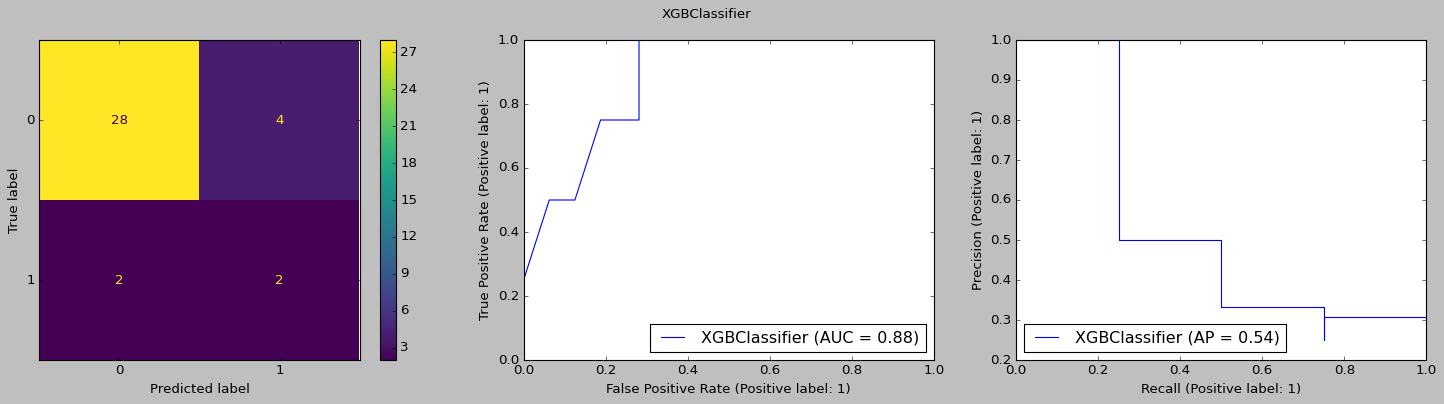

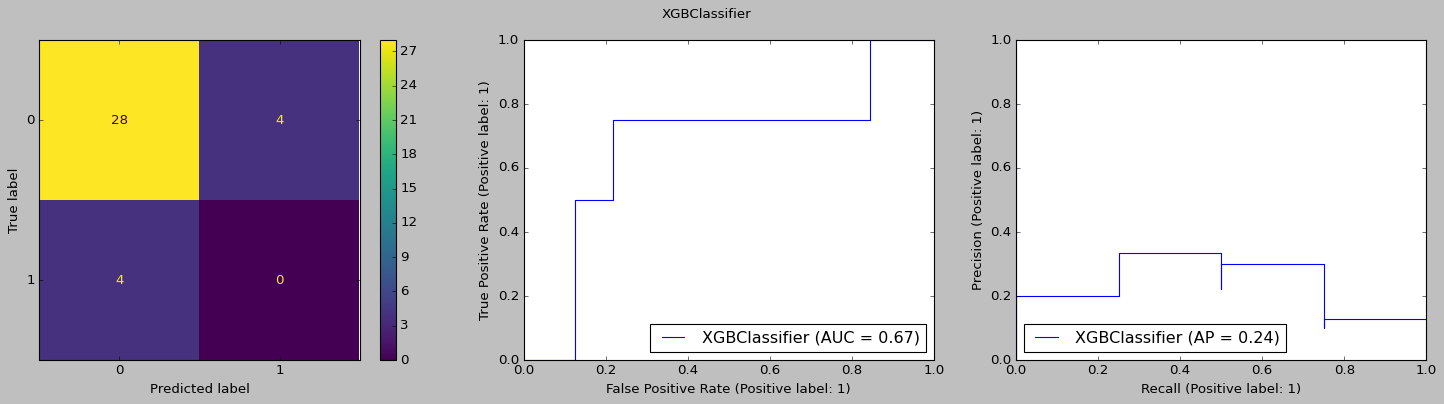

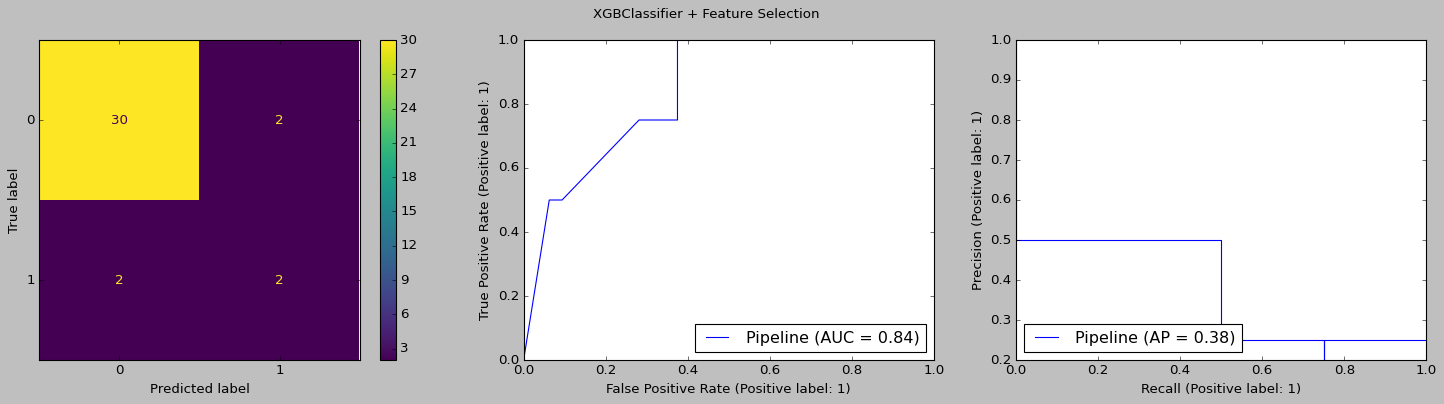

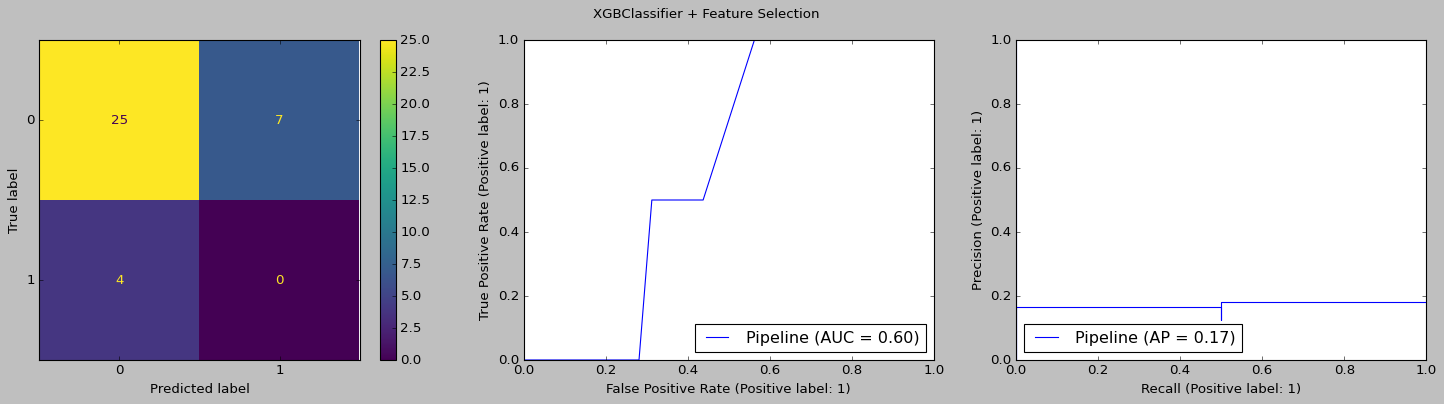

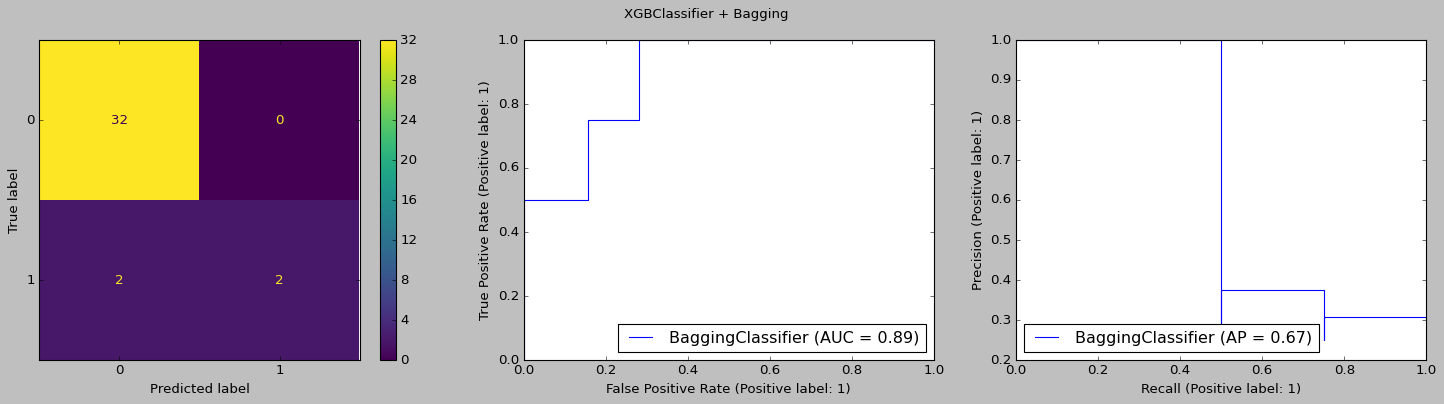

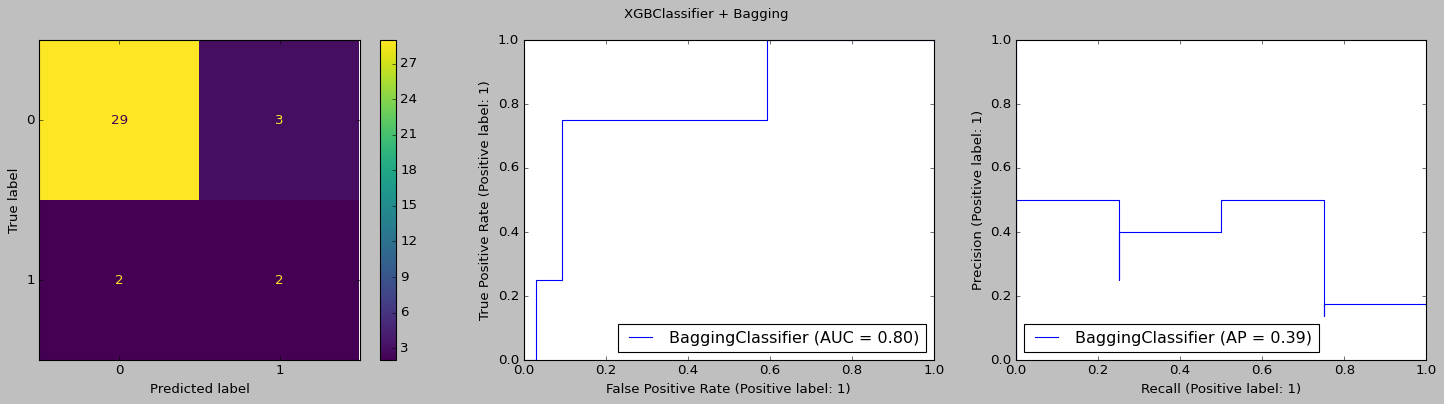

In [10]:
clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric = 'auc', n_estimators= 100, learning_rate=0.01,use_label_encoder=False, max_depth=15, n_jobs=18)

silent =False

xgb_results = {'basic': [apply_single_clf(clf, split_data,save_path = confusion_saves, timepoint=t, apply_feature_selection=False, bagging=False, silent=silent) for t in timepoints],
              'feature_selection': [apply_single_clf(clf, split_data,save_path = confusion_saves, timepoint=t, apply_feature_selection=True, bagging=False, silent=silent) for t in timepoints],
              'bagging':[apply_single_clf(clf, split_data,save_path = confusion_saves, timepoint=t, apply_feature_selection=False, bagging=True, silent=silent) for t in timepoints],
              }

xgb_df = pd.DataFrame()

for i in list(xgb_results.keys()):
    for j in range(len(timepoints)):
        xgb_df=xgb_df.append(xgb_results[i][j]['test_result']['results_df']).reset_index(drop=True)
        plot_km(xgb_results[i][j],split_data,folder='XGBoost',save_path = kaplan_saves)
xgb_df.sort_values(by='timepoint',inplace=True)
      
display(xgb_df)

In [11]:
# clf = Lasso()

# xgb_results = {'basic': [apply_single_clf(clf, split_data, timepoint=t, apply_feature_selection=False, bagging=False, silent=True) for t in timepoints],
#               'feature_selection': [apply_single_clf(clf, split_data, timepoint=t, apply_feature_selection=True, bagging=False, silent=True) for t in timepoints],
#               'bagging':[apply_single_clf(clf, split_data, timepoint=t, apply_feature_selection=False, bagging=True, silent=True) for t in timepoints],
#               }

# xgb_df = pd.DataFrame()

# for i in list(xgb_results.keys()):
#     for j in range(len(timepoints)):
#         xgb_df=xgb_df.append(xgb_results[i][j]['test_result']['results_df']).reset_index(drop=True)
#         plot_km(xgb_results[i][j],split_data,folder='SVC',save_path = kaplan_saves)
# xgb_df.sort_values(by='timepoint',inplace=True)
      
# display(xgb_df)

In [12]:
writer = pd.ExcelWriter(os.path.join(scores_saves,'classifier_scores.xlsx'), engine='xlsxwriter')
nb_df.to_excel(writer, sheet_name='Naive Bayes')
ada_df.to_excel(writer, sheet_name='AdaBoostedClassifier')
gbc_df.to_excel(writer, sheet_name='GradientBoostedClassifier')
xgb_df.to_excel(writer, sheet_name='XGboostedClassifier')
writer.save()


# Multi-timepoint Models

In [13]:
n_estimators = 100
learning_rate=0.01



classifiers = [GaussianNB(), AdaBoostClassifier(),GradientBoostingClassifier(n_estimators=n_estimators,learning_rate=learning_rate),xgb.XGBClassifier(objective='binary:logistic',eval_metric = 'logloss', n_estimators= n_estimators, learning_rate=learning_rate,use_label_encoder=False, max_depth=10, n_jobs=18)]

results = pd.DataFrame()
full_res =[]
for clf in classifiers:
    temp_res = apply_multi_clf(clf, split_data, repeat=100)
    full_res.append(temp_res)
    results=results.append(temp_res['results_df'])


GaussianNB:   0%|          | 0/100 [00:00<?, ?it/s]


TypeError: apply_single_clf() missing 1 required positional argument: 'save_path'

In [ ]:
for i in range(4):
    plot_km(full_res[i],split_data,folder='Multi',save_path = kaplan_saves,multi=True)

# Clinical Model